# Static traffic assignment iPython code
*** 
- [Section 1](#graph) upload the graph
- [Section 2](#demand) upload the demand
- [Section 3](#assignment) encode the all or nothing function
- TO DO

***
We want to solve the following problem (TAP):
\begin{align}
\min_{\textbf{h}} &\sum_{a} \int_{0}^{f_a} t_a(s)\; \text{d}s
\\
\text{s.t.  } & \;\; \textbf{f} = \Delta \textbf{h}
\\
& \;\; 
\textbf{h} \geq 0
\\
& \;\; 
A \textbf{h} = \textbf{d}
\end{align}

The static traffic assigment problem (STA) states the Wardrop conditions as the equivalent optimization problem above. 

The Wardrop conditions are as follows [[Patriksson](#references)]:
- Wardrop's first principle: all journey times are equal, and is less than the time experienced by a single vehicle on any other unused route.
- Wardrop's second principle: the average journey time is a minimum.

Notation:
- For $\left( p,q \right) \in C$ (an origin-destination pair) and route $r \in R_{pq}$ (the set of simple routes from $p$ to $q$), $c_{pqr}$ is the travel time.
- $h_{pqr}$ is the flow on the $r$ from $p$ to $q$.
- $\pi_{pq}$ is the shortest travel time from $p$ to $q$.
- $d_{pq}$ is the demand for the OD pair $(p,q)$.

The Wardrop User equilibrium conditions occurs if and only if the following is true for $l$ routes on $(p,q)$:

$$ c_{pq1} = ... = c_{pql} $$

This condition can be equilavently stated as

$$ h_{pqr} > 0 \implies c_{pqr} = \pi_{pq}, \forall r \in R_{pq} $$
$$ h_{pqr} = 0 \implies c_{pqr} \geq \pi_{pq}, \forall r \in R_{pq} $$

, which holds for all $(p,q) \in C$. The idea is that for all routes with flow, the travel time is optimal, and that for all paths with not flow the travel time is greater then or equal to optimal. This condition can be restated as the following alongside certain feasibility conditions:

$$ h_{pqr}(c_{pqr} - \pi_{pq}) = 0, \ \forall r \in R_{pq}, \ \forall (p,q) \in C $$

$$ c_{pqr} - \pi_{pq} \geq 0, \ \forall r \in R_{pq}, \ \forall (p,q) \in C $$

$$ \sum_{r \in R_{pq}} h_{pqr} = d_{pq}, \ \forall (p,q) \in C $$

$$ h_{pqr} \geq 0, \ \forall r \in R_{pq}, \ \forall (p,q) \in C $$

$$ \pi_{pq} \geq 0, \ \forall (p,q) \in C $$

TO DO: TRY TO HAVE A PROOF WHICH IS NOT IN THE PATRIKSSON BOOK: FROM THE 4 EQUATIONS ABOVE TO THE VARIATIONAL INEQUALITY: $c(h^\star)^\top(h-h^\star) \geq 0$.

Theorem 2.1 [[Patriksson](#references)] states that the Wardrop conditions are equivalent to the first order condition of the TAP problem listed above. The intuition behind the idea follows from taking the Lagrangian of the optimization problem using multipliers $\boldsymbol{\lambda}$ from the third constraint:

$$ L(\textbf{h},\boldsymbol{\lambda}) = T(\textbf{f}(\textbf{h})) + \sum_{(p,q) \in C} \lambda_{pq}(d_{pq} - \sum_{r \in R_{pq}} h_{pqr}) $$

The remaining proof uses the stationary of the Lagrangian and fact that the partial derivative of $T$ with respect to the flow along a certain route ($h_{pqr}$) is the travel time $c_{pqr}$ to rederive the Wardrop conditions. We can also interpret the multiplier $\boldsymbol{\lambda}$ as the minimum route cost between $p$ and $q$, so $\boldsymbol{\lambda}$ is $\boldsymbol{\pi}$.

### Variational Inequality Interpretation of Static Traffic Assignment [[Smith](#references)]

Let $\alpha$ denote the id of a link.

Let $f_{\alpha}$ denote flow on link $\alpha$.

Let $\delta_{r\alpha}$ be such that

$$ \delta_{r\alpha} = 
\left\{
\begin{array}{ll}
      0 & r \ contains \ link \ \alpha \\
      1 & otherwise
\end{array} 
\right. 
$$

Let $K$ denote the set of feasible flows $h$ such that the following conditions are satisfied:

$$ \sum_{r \in R_{pq}} h_{pqr} = d_{pq}, \ \forall (p,q) \in C $$

$$ \sum_{r \in R_{pq}} h_{pqr}\delta_{r\alpha} \ = \ f_{\alpha}, \ \forall (p,q) \in C, \alpha $$

#### Theorem

A vector $h^* \in K$ is an equilibrium patter if and only if it satisfies the following varitional inequality problem:

$$c(h^{ * })^{T}(h - h^{ * }) \geq 0, \forall h \in K $$

#### Proof

Let $c_{r}(\textbf{h})$ be the cost (ie travel time) of using route $r$ for flow vector $\textbf{h}$. Wardrop equilibrium says that for some route $r$, $s$, if $c_{r}(\textbf{h}) \geq c_{s}(\textbf{h})$ then the flow for route $r$, $h_r$, is 0:

$$c_{r}(\textbf{h}) \geq c_{s}(\textbf{h}) \implies h_r = 0$$

This implies that only the cheapest routes are used. Denote this with $\textbf{h}^*$.

We will define total cost of flow $\textbf{h}$ as
$$ c(\textbf{h})^{T}\textbf{h} $$

As the total cost is at least as great as that with $\textbf{h}^*$, the following is true:
$$ c(\textbf{h}^{*})^{T}\textbf{h} \geq c(\textbf{h}^{*})^{T}\textbf{h}^{*}, \ \forall h \in K \ \ (1)$$

Hence the Wardop Equilibria imply (1).

Now if the Wardop Equilibria were not satisfied then it must be the case the for some route $r$ the following is true:
$$c_{r}(\textbf{h}) > c_{s}(\textbf{h}) \ \text{and} \ h_r = 0$$

If we move flow from route $r$ to $s$, which has a cheaper route flow $\textbf{h}^{'}$, then we would reduce the total cost by $c(\textbf{h})^{T}\textbf{h}^{'} - c(\textbf{h})^{T}\textbf{h} > 0$, which does not satisfy the Wardrop conditons.

As it has been shown that the Wardrop conditions imply (1) and (by contrapostion) (1) implies the Wardrop conditions, they are equivalent. Hence,

$$ \text{Wardrop conditions} \ \equiv c(\textbf{h}^{*})^{T}(\textbf{h} - \textbf{h}^{*}) >= 0, \forall h \in K $$

## 0. Import some libraries useful for the project
***

In [10]:
%run -i 'network.py'

In [11]:
import numpy as np
import pandas as pd
from scipy import sparse
import scipy
import matplotlib.pyplot as plt

## 1. Import the road network and its characteristics <a id="graph"></a>
***
The road network is composed by:
- $G=(E,V)$ a **strongly connected oriented graph** with vertices $v\in V$ and edges $e\in E$
- $t_{0,e}\in\mathbb{R}_+$ the **free flow travel time** of the edge $e$, $\forall e\in E$
- $c_{e}\in\mathbb{R}_+$ the **flow capacity** of the edge $e$, $\forall e\in E$
- $B_e\in\mathbb{R}_+$ and $p_e\in\mathbb{N}_+$ two characteristics of the edge $e$ useful for estimating the travel time of vehicle on the edge $e$ given the flow of the edge $e$, $\forall e\in E$

Data are provided from https://github.com/bstabler/TransportationNetworks.
They are is the folder `data/`.

The road network and its characteristics are read in the file `network.py` with the function:
- `init_travel_time_function(network) : graph_wrapped`: takes as parameter a string which represent the path to the data file TNTP `network` and return in `graph_wrapped` the table that can be used to compute the travel time of every links, and the index of the free flow travel time, of the B, of the capacity and of the power columns.
_TO DO: Better explain this_

## 2. Import the road demand <a id="demand"></a>
***
The road demand is a matrix $r \in \mathbb{R}_+^{|V| \times |V|}$ where:
- $r_{o,d}$ is the demand between the origin $o\in V$ and the destination $d\in V$.

Remark that for most of the vertices $u,v\in V$, $r_{u,v}=0$ so the demand matrix is very sparse.

The road demand are read in the file `network.py` with the function:
- `read_demand(file): demand`: takes as parameter a string which represent the path to the data file TNTP `network` and return in `demand` a dictionary of keys based sparse matrix representing the demand $r$.

## 3. Define the link travel time as a function of the link flow <a id="travel_time"></a>
***
The travel time of every link $e\in E$ is given as a function of the flow on the link $f_e\in\mathbb{R}_+$ and of [the characteristics of the edge](#graph):
$$ t_e(f_e) = t_{0,e} \cdot \left( 1 + B_e \cdot \left(\frac{f_e}{c_e}\right)^{p_e} \right) $$
This is the classical BPR function as defined in [[Patriksson](#references)]. 

The function `travel_time(flow, graph_wrapped): travel_time` computes it: it gives the travel time vector for every link given the [graph_wrapped](#graph) and the vector of link flow.

A test is provided at the [end of the notebook](#tests).

In [15]:
def travel_time(flow, graph_wrapped):
    """
    Parameter: 
        flow: a vector that represents the flow of every links
        graph_wrapped: should be = (table_net, index_fft, index_B, index_capacity, index_power, index_init, index_term)
    Return:
        A travel time vector for every links given the flow allocation flow.
        
        The travel time of a link (one row of the table) is t(f) = t0 * (1 + B*(f/capacity)**power)
    """
    table_net, index_fft, index_B, index_capacity, index_power, index_init, index_term = graph_wrapped
    return table_net[:,index_fft] * (1 + table_net[:,index_B]*(flow/table_net[:,index_capacity])**table_net[:,index_power])

## 4. Import an encoding of the graph<a id="demand"></a>
***
The graph encoding is a matrix $r \in \mathbb{R}_+^{|V| \times |V|}$ where:
- $r_{o,d}$ is the ID of the link between the origin $o\in V$ and the destination $d\in V$.

The encoding of the graph is read in the file `network.py` with the function:
- `get_graph(graph_wrapped): graph`: takes as parameter a list the characterization of edges in the network and returns a dictionary that encodes link ID by origin-destination pairs.

## 5. Initialize Network <a id="assignment"></a>
***
Initialize the network by running the previously defined functions to generate the necessary data needed.

- `initialization(network) : graph_wrapped, demand, graph, nb_links`: TO DO

In [17]:
def initialization(network):
    """
    Parameter:
        network: the file name of the data 
    Return:
        graph_wrapped, demand, graph, nb_links using previously defined functions
    """
    graph_wrapped = init_travel_time_function(network)
    demand = read_demand(network)
    graph = get_graph(graph_wrapped)

    table_net, _, _, _, _, _, _ = graph_wrapped
    nb_links = table_net.shape[0]
    return graph_wrapped, demand, graph, nb_links

# we have the demand in the sparse matrix demand, and the travel_time function in travel_time
# we have the graph of the network in graph


## 6. Assignment <a id="assignment"></a>
***
Descent Algorithm: Frank-Wolfe

The following linearly constrained optimization problem

$$ \min_{x} f(x) $$

$$ \text{s.t} \ Ax = b, x \geq 0 $$

can be transformed by the Frank Wolfe algorithm into the following:

$$ \min_{y} \nabla f(x^k)^Ty $$

$$ \text{s.t} \ Ay = b, y \geq 0 $$

The algorithm tries to solve the problem iteratively, where on the kth iteration it uses a feasible solution $x^k$ to find the search direction $y$. The intuition for this comes from finding the solution of the first order approximation of the objective function rather than the solution to the objective itself:

$$ \min_{y} f(x^k) + \nabla f(x^k)^T(y-x^k) $$

Since we only care about finding the optimal $y$ for the problem we can ignore constants, so the problem is equivalent to

$$ \min_{y} \nabla f(x^k)^Ty $$

Once we've found this $y$, we do a line search in the direction $d = y - x^k$ to find the step size $\alpha_k$:

$$ \min_{0 \leq \alpha_k \leq 1} f(x^k + \alpha_{k}d) $$

***

In the case of the traffic assignment problem, the solution to the iterative optimization step $y$ is the all or nothing allocation of flow (named as all flow is placed all on a certain path and not others). This comes from the fact that as we are optimizing over linear constraints the solution is at a single vertex on the polytope that represents the feasible space, which represents the allocation of flow based on the shortest paths in solution (which is found using Dijkstra's Algorithm).

As with Frank Wolfe's algorithm, we undertaking line search using the potential function and use the bisection method to find the ideal step size. The bisection method is approximate as it relies on a resolution $r$ (at which higher values it is more accurate), though it has complexity $O(log \ r)$ so it is computationally efficient. Generally, the sequence $f(x^k)$ is monotonically decreasing for Frank Wolfe, though due to this approximation this is not always the case in our implementation. Exceptions to this loop invariance problem are recorded.

In [18]:
def franke_wolfe(network, should_print=True):
    # def put_on_shortest_path(faon, o_tmp, d_tmp, flow_tmp, tt, g, G):
    #     """
    #     Parameter:
    #         faon: current all or nothing flow allocation that the algorithm is building
    #         o_tmp: origin of the current od pair
    #         d_tmp: destination of the current od pair
    #         flow_tmp: demand of the current of pair
    #         tt: travel time on every links, tt[l] = travel time of the link l
    #         g: graph dictionary, g[node_init] = {node_term_1: link_from_init_to_term_1, node_term_2: link_from_init_to_term_2}
    #     Return:
    #         TO WRITE
    #     """
    #     dist_matrix, return_predecessors = dijkstra(G, return_predecessors = True) # change

    #     node_tmp = d_tmp
    #     # using the dijkstra, we build the fastest path and we put the flow on it.
    #     while node_tmp != o_tmp:
    #         node_tmp_d = return_predecessors[o_tmp][node_tmp]
    #         # Here we need the graph_dict to recover the link id from the nodes id.
    #         link_tmp = g[node_tmp_d+1][node_tmp+1] # this is very bad because we use node_tmp +1 and node_tmp_d + 1 instead of node_tmp and node_tmp_d
    #         faon[link_tmp] += flow_tmp
    #         node_tmp = node_tmp_d

    #     return faon

    # write pseudocode STA
    epsilon = 0.01

    # initialization
    graph_wrapped, demand, graph, nb_links = initialization(network)

    table_net, _, _, _, _, _, _ = graph_wrapped
    nb_links = table_net.shape[0]


    f = all_or_nothing(demand, travel_time(np.zeros(nb_links), graph_wrapped), graph)
    f_iter = []
    tt_iter = []
    incr_tt = []
    alpha = 1
    i = 0
    while alpha>epsilon and i<1000:
        f_iter.append(f)
        tt = travel_time(f, graph_wrapped)
        faon = all_or_nothing(demand, tt, graph)
        tt_iter.append(np.dot(tt,(f - faon)))
        alpha = line_search(lambda a : potential((1. - a) * f + a * faon, graph_wrapped))
        f = (1-alpha) * f + alpha * faon
        # loop invariant
        if i != 0 and tt_iter[i] > tt_iter[i-1]:
            incr_tt.append(i)
        i = i+1
    
    flow, cost = flow_cost_solution(network)
    
    if should_print:
        if len(incr_tt) > 0:
            print("Exceptions to loop variance occured in the following iterations: \n")
            print(str(incr_tt))
        print("Iterations: ", i)
        print(potential(flow, graph_wrapped))
        print(potential(f, graph_wrapped))
        print(np.linalg.norm(f-flow)/np.linalg.norm(flow))
    
    return [np.linalg.norm(f-flow,2) for f in f_iter], [potential(f_iter[i], graph_wrapped)-potential(f_iter[i+1], graph_wrapped) for i in range(len(f_iter)-1)], tt_iter[:]

norm_flow_loss_fw, potential_loss_fw, tt_iter_fw = franke_wolfe('data/SiouxFalls/SiouxFalls')

<NUMBER OF ZONES> 24
<TOTAL OD FLOW> 360600.0
<END OF METADATA>
Exceptions to loop variance occured in the following iterations: 

[4, 10, 21, 24, 26, 28, 30, 33, 35, 36, 41, 43, 46, 50, 52, 53, 56, 57, 58, 63, 67]
Iterations:  68
4434390.915720795
4444951.281618943
0.009339356199186341


## 6. Fukushima: A Modified Frank Wolfe Algorithm <a id="assignment"></a>
***
Fukushima explanation

In [19]:
def fukushima(network, should_print=True):
    # write pseudocode STA
    epsilon = 0.01

    # initialization
    graph_wrapped, demand, graph, nb_links = initialization(network)

    table_net, _, _, _, _, _, _ = graph_wrapped
    nb_links = table_net.shape[0]

    f = all_or_nothing(demand, travel_time(np.zeros(nb_links), graph_wrapped), graph)
    f_iter = []
    tt_iter = []

    f_iter.append(f)

    faons = []

    alpha = 1.0
    k = 1
    l = 2
    incr_tt = []

    while alpha>epsilon and k<1000:
        x_k = f_iter[-1]
        tt = travel_time(x_k, graph_wrapped)
        faon = all_or_nothing(demand, tt, graph) # y_k
        faons.append(faon)
        y_k = faon
        if np.dot(tt,(y_k - x_k)) == 0: # you can try as < epsilon
            print("Break")
            break

        q = min(k, l) - 1

        lamb = 1/(q+1)
        v_k = np.add.reduce([lamb*(faons[-(q+1):][i]) for i in range(q+1)]) - x_k
        w_k = y_k - x_k

        gamma1_k = np.dot(v_k/np.linalg.norm(v_k), tt)
        gamma2_k = np.dot(w_k/np.linalg.norm(w_k), tt)

        if gamma1_k < gamma2_k:
            d_k = v_k
        elif gamma1_k == gamma2_k:
            r = np.random.random()
            u_k = (r*v_k+(1-r)*w_k)
            d_k = u_k
        else:
            d_k = w_k
        alpha = line_search(lambda a : potential(x_k + a * d_k, graph_wrapped))
        f_iter.append(x_k + alpha*d_k)
        k = k + 1
        tt_iter.append(np.dot(tt,(f_iter[-1] - faon)))
    
    flow, cost = flow_cost_solution(network)
    
    if should_print:
        print("\nIterations: ", str(k-1))
        print("Alpha: ", alpha)
        print(potential(flow, graph_wrapped))
        print(potential(f_iter[k-1], graph_wrapped))
        print(np.linalg.norm(f_iter[-1]-flow)/np.linalg.norm(flow))
        
    return [np.linalg.norm(f-flow,2) for f in f_iter], [potential(f_iter[i], graph_wrapped)-potential(f_iter[i+1], graph_wrapped) for i in range(len(f_iter)-1)], tt_iter[:]

norm_flow_loss_fk, potential_loss_fk, tt_iter_fk = fukushima('data/SiouxFalls/SiouxFalls')

<NUMBER OF ZONES> 24
<TOTAL OD FLOW> 360600.0
<END OF METADATA>

Iterations:  44
Alpha:  0.00886777602366884
4434390.915720795
4442850.621544741
0.012672443784807605


In [20]:
def plot(network, algs):
    norms = []
    potentials = []
    tts = []
    for alg in algs:
        if alg == "fw":
            norm_flow_loss, potential_loss, tt_iter = franke_wolfe(network, False)
        elif alg == "fk":
            norm_flow_loss, potential_loss, tt_iter = fukushima(network, False)
            
        norms.append(norm_flow_loss)
        potentials.append(potential_loss)
        tts.append(tt_iter)
            
    plt.figure()
    plt.title("Norm flow loss")
    plt.ylabel("Norm loss")
    plt.xlabel("No of iterations")
    for i in range(len(algs)):
        plt.plot(norms[i], label=algs[i])
    plt.legend(loc="upper right")
    plt.show()

    plt.figure()
    plt.title("Potential loss over time")
    plt.ylabel("Potential loss")
    plt.xlabel("No of iterations")
    for i in range(len(algs)):
        plt.plot(potentials[i], label=algs[i])
    plt.legend(loc="upper right")
    plt.show()

    plt.figure()
    plt.title("Total time loss over time")
    plt.ylabel("Total time loss")
    plt.xlabel("No of iterations")
    for i in range(len(algs)):
        plt.plot(tts[i], label=algs[i])
    plt.legend(loc="upper right")
    plt.show()

<NUMBER OF ZONES> 24
<TOTAL OD FLOW> 360600.0
<END OF METADATA>
<NUMBER OF ZONES> 24
<TOTAL OD FLOW> 360600.0
<END OF METADATA>


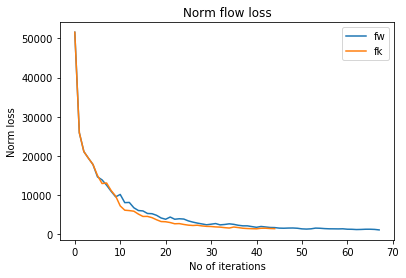

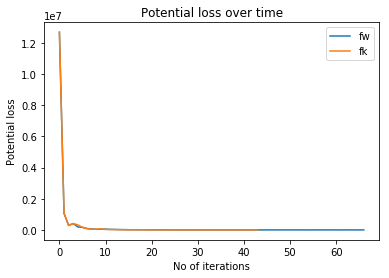

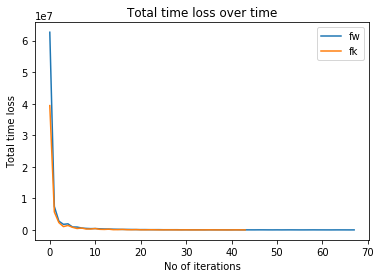

In [21]:
plot('data/SiouxFalls/SiouxFalls', ["fw", "fk"])

<NUMBER OF ZONES> 38 
<TOTAL OD FLOW>  104694.40 
<END OF METADATA>
<NUMBER OF ZONES> 38 
<TOTAL OD FLOW>  104694.40 
<END OF METADATA>


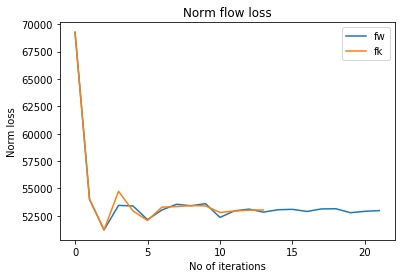

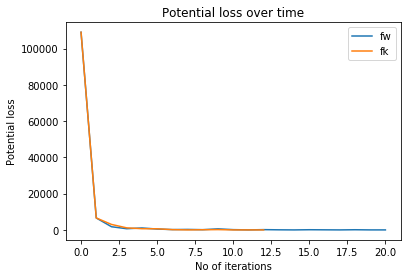

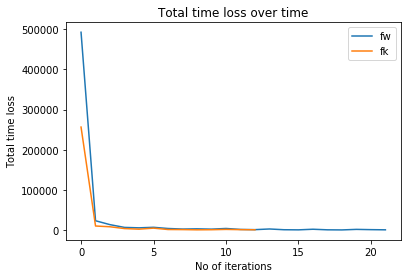

In [191]:
plot('data/Anaheim/Anaheim', ["fw", "fk"])

## 10.Tests <a id="tests"></a>
***
Here are a bunch of tests to verify that our code is correct.

### 10.1 Test of the [travel time function](#travel_time)
- `flow_cost_solution(network) : optimal_flow, cost_solution`: takes as parameter a string which represent the path to the data file tntp `network` and return the flow and the cost of the STA solution by reading it in the data provided.
- `test_travel_time_function(network, graph)` tests if travel_time gives the correct cost when the optimal flow allocation is given in the data (like in __data/SiouxFalls/SiouxFalls__)

In [24]:
from network import flow_cost_solution

def test_travel_time_function(network, graph):
    """
    Parameter:
        file: a string which represent the path to the data file tntp
    Using the flow.tntp file (solutions) and the travel time function,
    the function tests if travel_time(flow_solutions) == cost_solutions
    Return:
        A vector of the differences between travel_time(flow_solutions) and cost_solutions for every links
    """
    flow, cost_solution = flow_cost_solution(network)
    print(np.linalg.norm(travel_time(flow, graph) - cost_solution))
    return travel_time(flow, graph) - cost_solution

# test if our travel_time function is correct
# network = 'data/SiouxFalls/SiouxFalls'
# network = 'data/Eastern-Massachusetts/EMA'
# network = 'data/Berlin-Tiergarten/berlin-tiergarten'
for network in {'data/SiouxFalls/SiouxFalls', 'data/Anaheim/Anaheim'}:
    graph_wrapped = init_travel_time_function(network)
    test_travel_time_function(network, graph_wrapped)

3.807809309113039e-15
3.277847697668423e-14


## References <a id="references"></a>
***
- [Patriksson] The Traffic Assignment Problem - Models and Methods, M. Patriksson
- [Smith] The Existence, Uniqueness and Stability of Traffic Equilibria, M. J. Smith